In [1]:
%matplotlib widget

import matplotlib
import math
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import HTML

# The setup
Demonstrate our message and unmodulated carrier signals

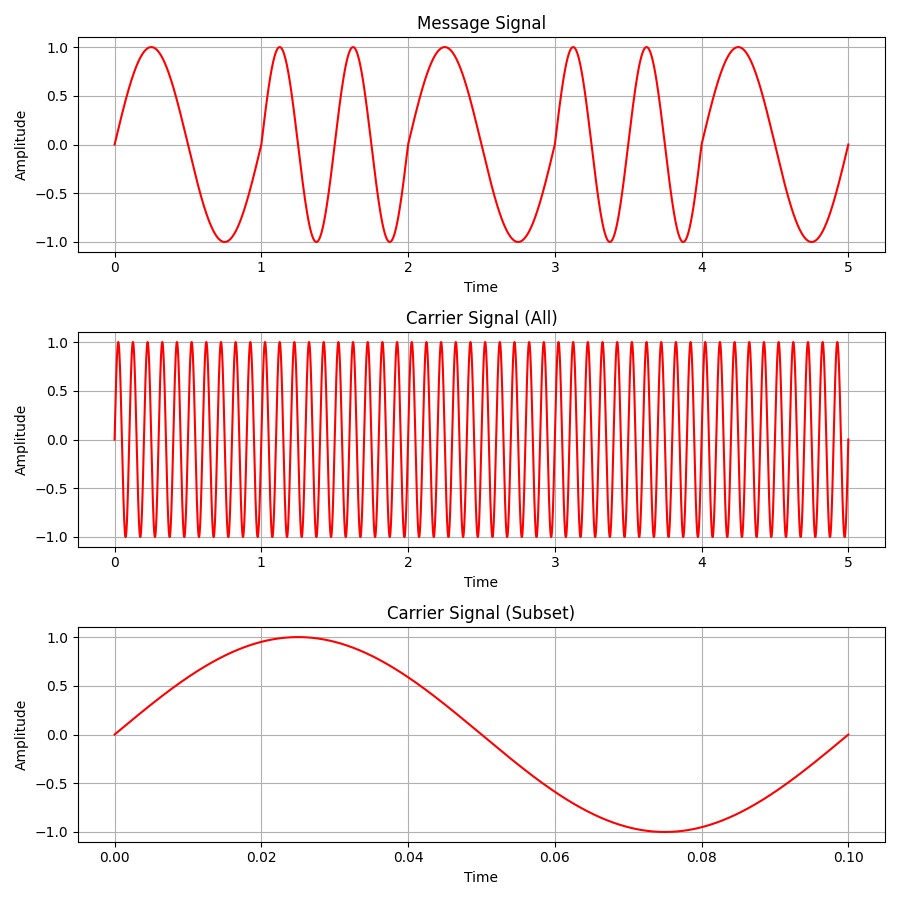

In [2]:
sample_rate = 100000
duration_secs = 5

T = np.linspace(0, 5,sample_rate * duration_secs,)

# Frequency of the message signal changes over time
def f_m(t):
    if int(t) in [0,2,4]: return 1
    else: return 2

# Frequency of the carrier does not change (Before modulation anyways)
f_c = 10
message = [1.0 * np.sin(2*np.pi*t*f_m(t)) for t in T]
carrier = 1.0 * np.sin(2*np.pi*T*f_c)

# PLOT
fig, (message_ax, carrier_ax, carrier_slice_ax) = plt.subplots(3, figsize=(9,9))

# Plot message signal
message_ax.plot(T,message, color="r", label="Signal 1")
message_ax.set_title("Message Signal")
message_ax.set_xlabel("Time")
message_ax.set_ylabel("Amplitude")
message_ax.grid()

# Plot carrier signal (All)
carrier_ax.plot(T,carrier, color="r", label="Signal 1")
carrier_ax.set_title("Carrier Signal (All)")
carrier_ax.set_xlabel("Time")
carrier_ax.set_ylabel("Amplitude")
carrier_ax.grid()
fig.tight_layout()

# Plot carrier signal (Subset)
n_samps_subset = sample_rate//10
carrier_slice_ax.plot(T[:n_samps_subset], carrier[:n_samps_subset], color="r", label="Signal 1")
carrier_slice_ax.set_title("Carrier Signal (Subset)")
carrier_slice_ax.set_xlabel("Time")
carrier_slice_ax.set_ylabel("Amplitude")
carrier_slice_ax.grid()
fig.tight_layout()

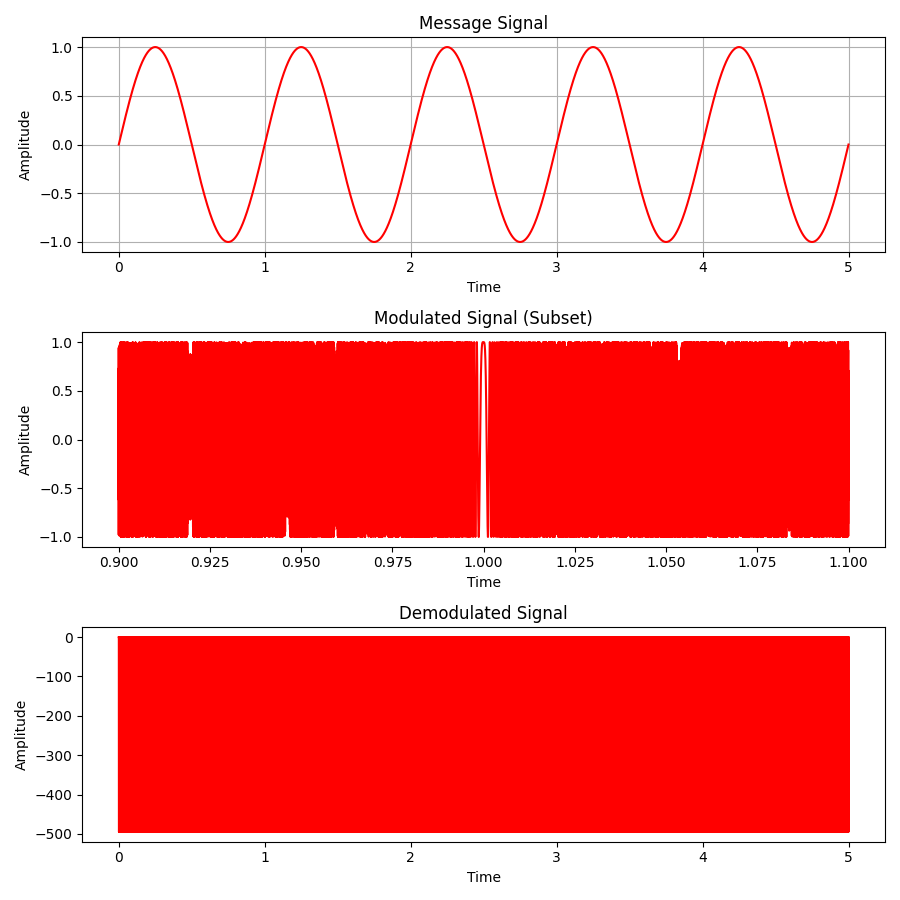

In [3]:
# Frequency of the message signal changes over time
def f_m(t):
    if int(t) in [0,2,4]: return 1
    else: return 1
    
def frequency_modulator(T, sensitivity, a_c, f_c, f_m):
    message = []
    modulated = []
    total = 0
    for t in T:
        mes = 1.0 * np.sin(2*np.pi*t*f_m(t))
        total += mes
        total = (total + np.pi) % (2 * np.pi) - np.pi
#         total=0
        
        i = a_c * np.cos( 2*np.pi*f_c*t + 2*np.pi*sensitivity*total)
#         i = a_c * np.cos( 2*np.pi*f_c*t)
        
        message.append(mes)
        modulated.append(i)
    return np.asarray(message), np.asarray(modulated)

def frequency_demodulator(X, input_rate_sps, max_deviation_Hz=100):
        DEVIATION_X_SIGNAL = 0.99 / (np.pi * max_deviation_Hz / (input_rate_sps / 2))
        angles = np.angle(X)

        # Find the differences between the angles
        # Outputs |angles|-1, hence why we are applying holdover
        rotations = np.ediff1d(angles)

        # Pin rotations to [-pi, pi]
        # Note that pinning to [0, 2pi] leads to very bad audio
        rotations = (rotations + np.pi) % (2 * np.pi) - np.pi

        # Convert rotations to baseband signal 
        output_raw = np.multiply(rotations, DEVIATION_X_SIGNAL)
#         output_raw = np.clip(output_raw, -0.999, +0.999)

        return output_raw


message, modulated = frequency_modulator(T, sensitivity=1.0, a_c=1.0, f_c=50, f_m=f_m)
demodulated = frequency_demodulator(modulated, sample_rate)

# PLOT
fig, (message_ax, modulated_ax, demodulated_ax) = plt.subplots(3, figsize=(9,9))

# Plot message signal
message_ax.plot(T,message, color="r", label="Signal 1")
message_ax.set_title("Message Signal")
message_ax.set_xlabel("Time")
message_ax.set_ylabel("Amplitude")
message_ax.grid()

# Plot carrier signal (All)
start = int(0.9*sample_rate)
stop = int(1.1*sample_rate)
modulated_ax.plot(T[start:stop], modulated[start:stop], color="r", label="Signal 1")
modulated_ax.set_title("Modulated Signal (Subset)")
modulated_ax.set_xlabel("Time")
modulated_ax.set_ylabel("Amplitude")

# Plot demodulated
demodulated_ax.plot(T[:-1], demodulated, color="r", label="Signal 1")
demodulated_ax.set_title("Demodulated Signal")
demodulated_ax.set_xlabel("Time")
demodulated_ax.set_ylabel("Amplitude")
# modulated_ax.grid()
fig.tight_layout()

This is the best I have so far but its busted for two reasons:
1. Modulator is operating on the single tone assumption, so its not a true modulator
2. Demodulator is written for complex, but all of this is real. IDK why it doesn't throw an error

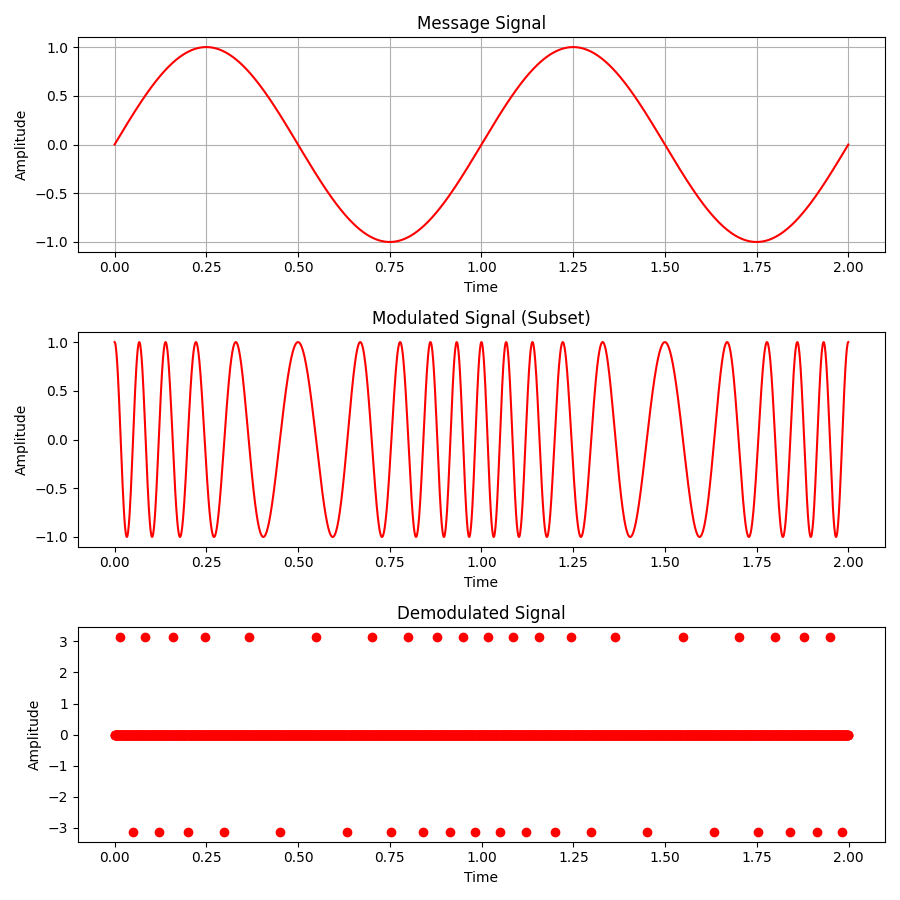

In [4]:
# Frequency of the message signal changes over time
sample_rate = 1000
duration_secs = 2
T = np.linspace(0, duration_secs,sample_rate * duration_secs,)
f_c = 10
sensitivity = 5.0

def f_m(t):
    if int(t) in [0,2,4]: return 1
    else: return 1
    
def frequency_modulator(T, sensitivity, a_c, f_c, f_m):
    message = []
    modulated = []
    total = 0
    for t in T:
        mes = 1.0 * np.sin(2*np.pi*t*f_m(t))
        total += mes
        total = (total + np.pi) % (2 * np.pi) - np.pi
#         total=0
        
#         i = a_c * np.cos( 2*np.pi*f_c*t + 2*np.pi*sensitivity*total)
        i = a_c * np.cos( 2*np.pi*f_c*t + (sensitivity/f_m(t))*np.sin(2*np.pi*f_m(t)*t))
#         i = a_c * np.cos( 2*np.pi*f_c*t)
        
        message.append(mes)
        modulated.append(i)
    return np.asarray(message), np.asarray(modulated)

def frequency_demodulator(X, input_rate_sps, max_deviation_Hz=100):
        DEVIATION_X_SIGNAL = 0.99 / (np.pi * max_deviation_Hz / (input_rate_sps / 2))
        angles = np.angle(X)
#         return angles

        # Find the differences between the angles
        # Outputs |angles|-1, hence why we are applying holdover
        rotations = np.ediff1d(angles)
        return rotations
        # Pin rotations to [-pi, pi]
        # Note that pinning to [0, 2pi] leads to very bad audio
        rotations = (rotations + np.pi) % (2 * np.pi) - np.pi

        # Convert rotations to baseband signal 
        output_raw = np.multiply(rotations, DEVIATION_X_SIGNAL)
        output_raw = np.clip(output_raw, -0.999, +0.999)

        return output_raw

message, modulated = frequency_modulator(T, sensitivity=sensitivity, a_c=1.0, f_c=f_c, f_m=f_m)
demodulated = frequency_demodulator(modulated, sample_rate)

# PLOT
fig, (message_ax, modulated_ax, demodulated_ax) = plt.subplots(3, figsize=(9,9))

# Plot message signal
message_ax.plot(T,message, color="r", label="Signal 1")
message_ax.set_title("Message Signal")
message_ax.set_xlabel("Time")
message_ax.set_ylabel("Amplitude")
message_ax.grid()

# Plot carrier signal (All)
start = int(0.9*sample_rate)
stop = int(1.1*sample_rate)
start = int(0*sample_rate)
stop = int(duration_secs*sample_rate)
modulated_ax.plot(T[start:stop], modulated[start:stop], color="r", label="Signal 1")
modulated_ax.set_title("Modulated Signal (Subset)")
modulated_ax.set_xlabel("Time")
modulated_ax.set_ylabel("Amplitude")

# Plot demodulated
demodulated_ax.scatter(T[:-1], demodulated, color="r", label="Signal 1")
# demodulated_ax.plot(T, demodulated, color="r", label="Signal 1")
demodulated_ax.set_title("Demodulated Signal")
demodulated_ax.set_xlabel("Time")
demodulated_ax.set_ylabel("Amplitude")
# modulated_ax.grid()

fig.tight_layout()

# Try again, with Hilbert Transform

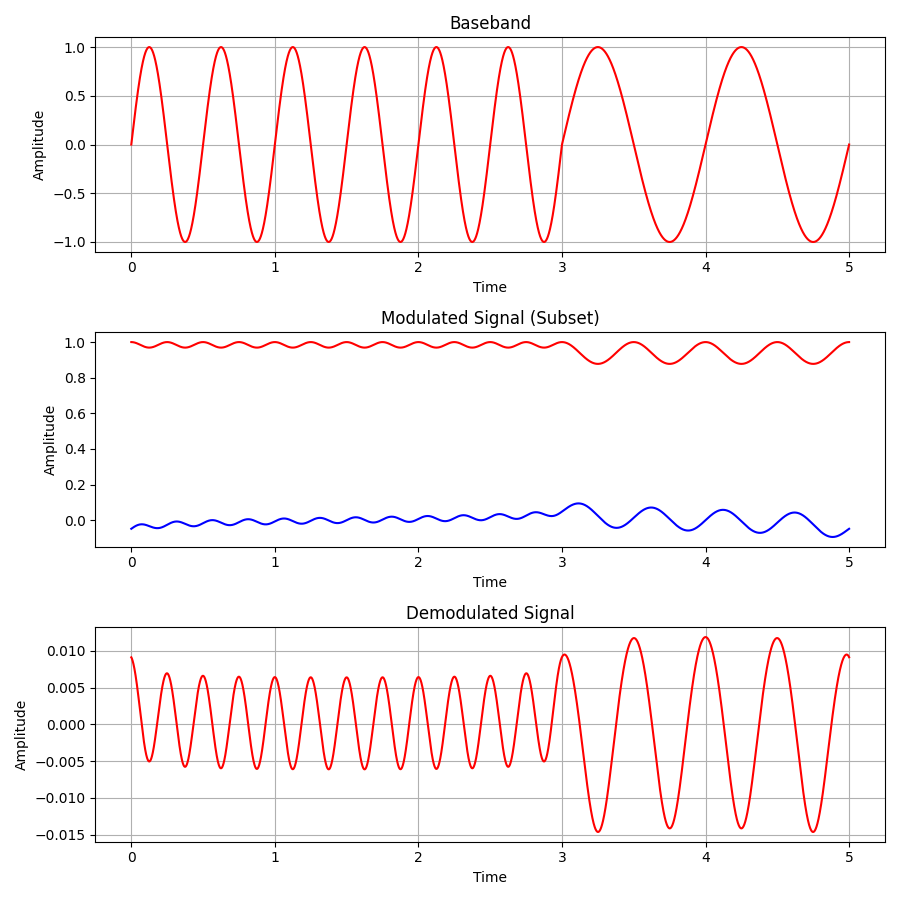

In [5]:
from scipy.signal import hilbert

# Frequency of the message signal changes over time
sample_rate = 10000
duration_secs = 5
T = np.linspace(0, duration_secs,sample_rate * duration_secs,)
f_c = 0
sensitivity = 0.5
max_deviation_Hz = 10

def f_m(t):
    if t < 3: return 2
    else: return 1
    
def frequency_modulator(T, sensitivity, a_c, f_c, f_m):
    message = []
    modulated = []
    total = 0
    for t in T:
        mes = 1.0 * np.sin(2*np.pi*t*f_m(t))
        total += mes
        total = (total + np.pi) % (2 * np.pi) - np.pi
        
        i = a_c * np.cos( 2*np.pi*f_c*t + (sensitivity/f_m(t))*np.sin(2*np.pi*f_m(t)*t))
        
        message.append(mes)
        modulated.append(i)
    return np.asarray(message), np.asarray(modulated)

def frequency_demodulator(X, input_rate_sps, max_deviation_Hz=10):
        DEVIATION_X_SIGNAL = 0.99 / (np.pi * max_deviation_Hz / (input_rate_sps / 2))
        angles = np.angle(X)
        rotations = np.ediff1d(angles)
        rotations = (rotations + np.pi) % (2 * np.pi) - np.pi
        output_raw = np.multiply(rotations, DEVIATION_X_SIGNAL)
        output_raw = np.clip(output_raw, -0.999, +0.999)

        return output_raw

baseband, modulated = frequency_modulator(T, sensitivity=sensitivity, a_c=1.0, f_c=f_c, f_m=f_m)
modulated = hilbert(modulated)
demodulated = frequency_demodulator(modulated, sample_rate, max_deviation_Hz)

# PLOT
fig, (message_ax, modulated_ax, demodulated_ax) = plt.subplots(3, figsize=(9,9))

# Plot baseband
message_ax.plot(T,baseband, color="r", label="Signal 1")
message_ax.set_title("Baseband")
message_ax.set_xlabel("Time")
message_ax.set_ylabel("Amplitude")
message_ax.grid()

# Plot modulated signal (All)
start = int(0.9*sample_rate)
stop = int(1.1*sample_rate)
start = int(0*sample_rate)
stop = int(duration_secs*sample_rate)
modulated_ax.plot(T[start:stop], modulated[start:stop].real, color="r", label="Signal 1 real")
modulated_ax.plot(T[start:stop], modulated[start:stop].imag, color="b", label="Signal 1 imag")
modulated_ax.set_title("Modulated Signal (Subset)")
modulated_ax.set_xlabel("Time")
modulated_ax.set_ylabel("Amplitude")

# Plot demodulated
demodulated_ax.plot(T[:-1], demodulated, color="r", label="Signal 1")
# demodulated_ax.plot(T, demodulated, color="r", label="Signal 1")
demodulated_ax.set_title("Demodulated Signal")
demodulated_ax.set_xlabel("Time")
demodulated_ax.set_ylabel("Amplitude")
demodulated_ax.grid()

fig.tight_layout()

# Interactive with Hilbert, using single tone FM equation
Sample rate does not effect, max deviation scales, sensitivity is the real issue here

OK so, if we actually have a f_c > 0, then everything looks sorta ok. But if we have f_c = 0 (which is what baseband would be), we get a demod frequency 2\*baseband

interactive(children=(FloatSlider(value=2.7, description='sensitivity', max=10.0), IntSlider(value=10, descrip…

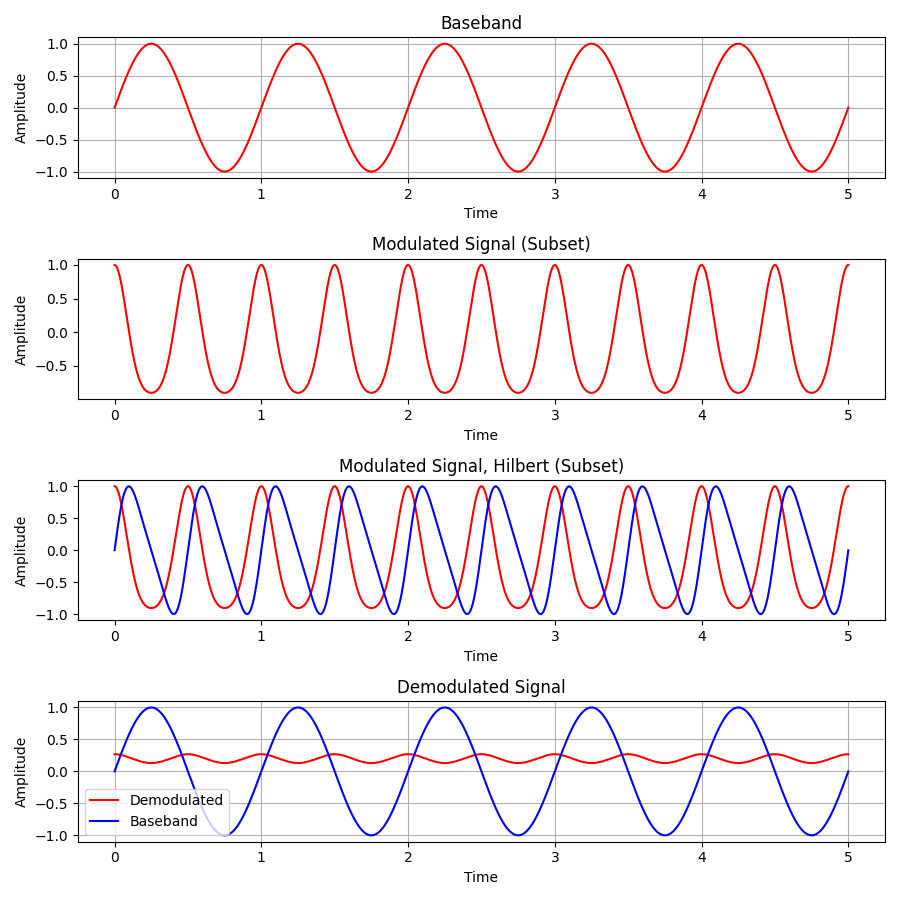

In [6]:
from scipy.signal import hilbert
duration_secs = 5

fig, (message_ax, modulated_ax, modulated_hilb_ax, demodulated_ax) = plt.subplots(4, figsize=(9,9))

@widgets.interact(
    sensitivity = (0, 10, 0.1),
    max_deviation_Hz = (0, 1000, 1),
    f_1 = (1,100,1),
    f_2 = (1,100,1),
    sample_rate = (1, 100000, 1),
    f_c = (0, 1000, 1)
)
def interact(
    sensitivity=2.7,
    max_deviation_Hz=10,
    f_1=1,
    f_2=1,
    sample_rate=10000,
    f_c=0,
):
    T = np.linspace(0, duration_secs,sample_rate * duration_secs,)

    def f_m(t):
        if t < 3: return f_1
        else: return f_2

    def frequency_modulator(T, sensitivity, a_c, f_c, f_m):
        message = []
        modulated = []
        for t in T:
            mes = 1.0 * np.sin(2*np.pi*t*f_m(t))
            i = a_c * np.cos( 2*np.pi*f_c*t + (sensitivity/f_m(t))*mes)

            message.append(mes)
            modulated.append(i)
        return np.asarray(message), np.asarray(modulated)

    def frequency_demodulator(X, input_rate_sps, max_deviation_Hz=10):
            DEVIATION_X_SIGNAL = 0.99 / (np.pi * max_deviation_Hz / (input_rate_sps / 2))
            angles = np.angle(X)
            rotations = np.ediff1d(angles)
            rotations = (rotations + np.pi) % (2 * np.pi) - np.pi
            output_raw = np.multiply(rotations, DEVIATION_X_SIGNAL)
            output_raw = np.clip(output_raw, -0.999, +0.999)

            return output_raw

    baseband, modulated = frequency_modulator(T, sensitivity=sensitivity, a_c=1.0, f_c=f_c, f_m=f_m)
    modulated_hilb = hilbert(modulated)
    demodulated = frequency_demodulator(modulated_hilb, sample_rate, max_deviation_Hz)

    # PLOT
    message_ax.clear()
    modulated_ax.clear()
    modulated_hilb_ax.clear()
    demodulated_ax.clear()
    
    # Plot baseband
    message_ax.plot(T,baseband, color="r", label="Signal 1")
    message_ax.set_title("Baseband")
    message_ax.set_xlabel("Time")
    message_ax.set_ylabel("Amplitude")
    message_ax.grid()

    # Plot modulated signal (All)
    start = int(0.9*sample_rate)
    stop = int(1.1*sample_rate)
    start = int(0*sample_rate)
    stop = int(duration_secs*sample_rate)
    modulated_ax.plot(T[start:stop], modulated[start:stop].real, color="r", label="Signal 1 real")
    modulated_ax.set_title("Modulated Signal (Subset)")
    modulated_ax.set_xlabel("Time")
    modulated_ax.set_ylabel("Amplitude")
    
    # Plot modulated signal (All)
    start = int(0.9*sample_rate)
    stop = int(1.1*sample_rate)
    start = int(0*sample_rate)
    stop = int(duration_secs*sample_rate)
    modulated_hilb_ax.plot(T[start:stop], modulated_hilb[start:stop].real, color="r", label="Signal 1 real")
    modulated_hilb_ax.plot(T[start:stop], modulated_hilb[start:stop].imag, color="b", label="Signal 1 imag")
    modulated_hilb_ax.set_title("Modulated Signal, Hilbert (Subset)")
    modulated_hilb_ax.set_xlabel("Time")
    modulated_hilb_ax.set_ylabel("Amplitude")

    # Plot demodulated and baseband
    demodulated_ax.plot(T[:-1], demodulated, color="r", label="Demodulated")
    demodulated_ax.plot(T[:-1], baseband[:-1], color="b", label="Baseband")
    # demodulated_ax.plot(T, demodulated, color="r", label="Signal 1")
    demodulated_ax.set_title("Demodulated Signal")
    demodulated_ax.set_xlabel("Time")
    demodulated_ax.set_ylabel("Amplitude")
    demodulated_ax.grid()
    demodulated_ax.legend()

    fig.tight_layout()

# Hilbert, using general FM Equation and complex

interactive(children=(FloatSlider(value=0.7, description='sensitivity_times_100', step=0.001), IntSlider(value…

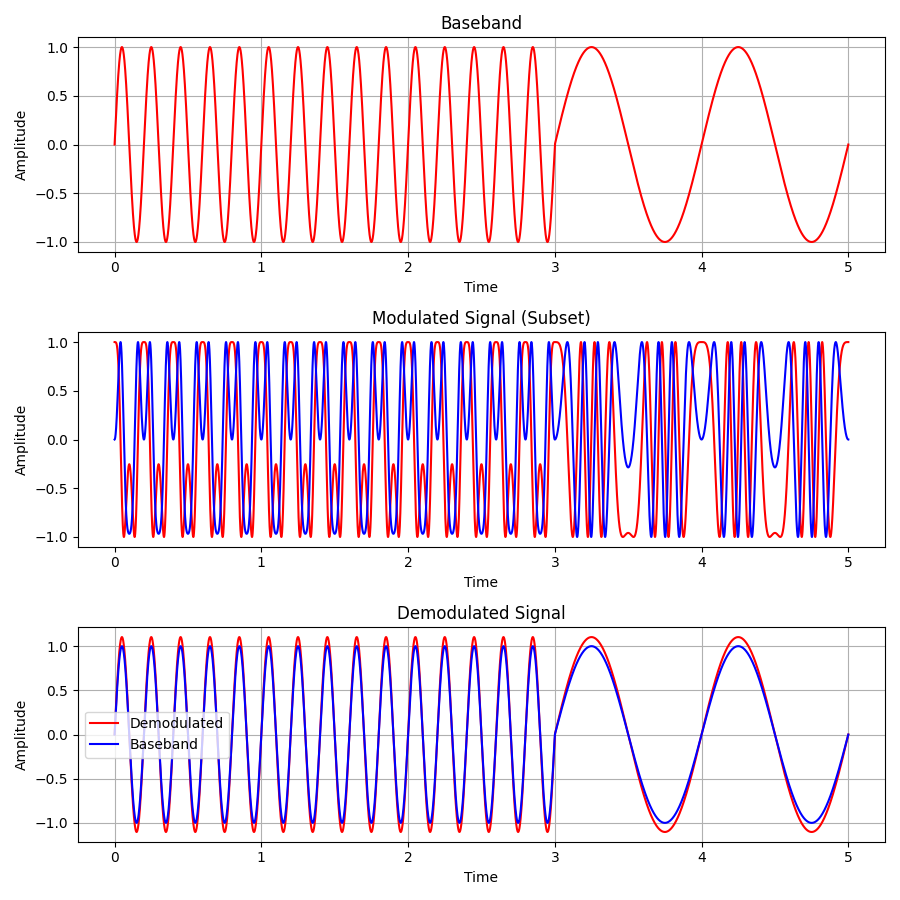

In [7]:
from scipy.signal import hilbert
duration_secs = 5

fig, (message_ax, modulated_ax, demodulated_ax) = plt.subplots(3, figsize=(9,9))

@widgets.interact(
    sensitivity_times_100 = (0, 100, 0.001),
    max_deviation_Hz = (0, 1000, 1),
    f_1 = (1,100,1),
    f_2 = (1,100,1),
    sample_rate = (1, 100000, 1),
    f_c = (0, 1000, 1)
)
def interact(
    sensitivity_times_100=0.7,
    max_deviation_Hz=10,
    f_1=5,
    f_2=1,
    sample_rate=10000,
    f_c=0,
):
    T = np.linspace(0, duration_secs,sample_rate * duration_secs,)
    sensitivity = sensitivity_times_100 / 100
    def f_m(t):
        if t < 3: return f_1
        else: return f_2

    def frequency_modulator(T, sensitivity, a_c, f_c, f_m):
        message = []
        modulated = []
        total = 0
        for t in T:
            mes = 1.0 * np.sin(2*np.pi*t*f_m(t))
            total += sensitivity*mes
            total = (total + np.pi) % (2 * np.pi) - np.pi
            
            out = np.cos(total)+1.0j*np.sin(total)

            message.append(mes)
            modulated.append(out)
        return np.asarray(message), np.asarray(modulated)

    def frequency_demodulator(X, input_rate_sps, max_deviation_Hz=10):
            DEVIATION_X_SIGNAL = 0.99 / (np.pi * max_deviation_Hz / (input_rate_sps / 2))
            angles = np.angle(X)
            rotations = np.ediff1d(angles)
            rotations = (rotations + np.pi) % (2 * np.pi) - np.pi
            output_raw = np.multiply(rotations, DEVIATION_X_SIGNAL)
#             output_raw = np.clip(output_raw, -0.999, +0.999)

            return output_raw

    baseband, modulated = frequency_modulator(T, sensitivity=sensitivity, a_c=1.0, f_c=f_c, f_m=f_m)
    demodulated = frequency_demodulator(modulated, sample_rate, max_deviation_Hz)

    # PLOT
    message_ax.clear()
    modulated_ax.clear()
    modulated_hilb_ax.clear()
    demodulated_ax.clear()
    
    # Plot baseband
    message_ax.plot(T,baseband, color="r", label="Signal 1")
    message_ax.set_title("Baseband")
    message_ax.set_xlabel("Time")
    message_ax.set_ylabel("Amplitude")
    message_ax.grid()

    # Plot modulated signal (All)
    start = int(0.9*sample_rate)
    stop = int(1.1*sample_rate)
    start = int(0*sample_rate)
    stop = int(duration_secs*sample_rate)
    modulated_ax.plot(T[start:stop], modulated[start:stop].real, color="r", label="Signal 1 real")
    modulated_ax.plot(T[start:stop], modulated[start:stop].imag, color="b", label="Signal 1 imag")
    modulated_ax.set_title("Modulated Signal (Subset)")
    modulated_ax.set_xlabel("Time")
    modulated_ax.set_ylabel("Amplitude")
    

    # Plot demodulated and baseband
    demodulated_ax.plot(T[:-1], demodulated, color="r", label="Demodulated")
    demodulated_ax.plot(T[:-1], baseband[:-1], color="b", label="Baseband")
    # demodulated_ax.plot(T, demodulated, color="r", label="Signal 1")
    demodulated_ax.set_title("Demodulated Signal")
    demodulated_ax.set_xlabel("Time")
    demodulated_ax.set_ylabel("Amplitude")
    demodulated_ax.grid()
    demodulated_ax.legend()

    fig.tight_layout()